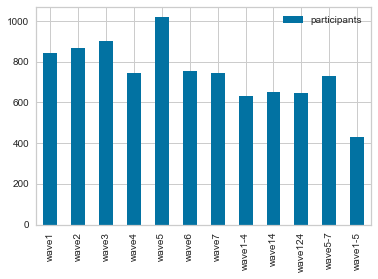

In [1]:
#Steps 1-3
import numpy as np
import pandas as pd
import pandas_profiling as pp
from IPython.display import display, HTML
import pymannkendall as mk
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, cross_validate, cross_val_predict
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ipynb.fs.full.script
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statistics import *

%matplotlib inline
pd.options.display.max_columns = None

pd.options.display.max_rows = 10
pd.options.display.width = 200
np.set_printoptions(precision = 4, suppress = True) 

legit_classes1 = [67,71,72,74,77,78,79,81,83,86,100,101,103,121,122,125,126,127,129,130,131,133,135,138]
legit_classes2 = [73,74,78,81,82,86,100,103,124,125,131,133,135,141,250,251,256,258,259,261,262,263,272,273,277,279,290,291,292,296,297,298,299,300,301,302,303,304,305,306,307,308,310]
participants = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/8. Metadata/Participant_Info.csv", sep= ';')

par_w1 = participants["W1"] == 1
par_w2 = participants["W2"] == 1
par_w3 = participants["W3"] == 1
par_w4 = participants["W4"] == 1
par_w5 = participants["W5"] == 1
par_w6 = participants["W6"] == 1
par_w7 = participants["W7"] == 1

total1 = len(participants[par_w1])
total2 = len(participants[par_w3])
total3 = len(participants[par_w2])
total4 = len(participants[par_w4])
total5 = len(participants[par_w5])
total6 = len(participants[par_w6])
total7 = len(participants[par_w7])
total1_4 = len(participants[par_w1 & par_w2 & par_w3 & par_w4])
total14 = len(participants[par_w1 & par_w4])
total124 = len(participants[par_w1 & par_w2 & par_w4])
total5_7 = len(participants[par_w5 & par_w6 & par_w7])
total1_5 = len(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5])

par_per_wave = pd.DataFrame({
    'participants': [total1, total2, total3, total4, total5, total6, total7, total1_4, total14, total124, total5_7, total1_5]}, index=['wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave1-4', 'wave14','wave124', 'wave5-7', 'wave1-5'])

par_per_wave.plot.bar()


#display(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5 & par_w6 & par_w7])
#print(participants[par_w1 & par_w2 & par_w3 & par_w4].count)

In [2]:
#getting participants from 5 to 7
participants5_7 = participants[['Child','Class_Y3']][par_w5 & par_w6 & par_w7]
participants5_7 = participants5_7[participants5_7["Class_Y3"].isin(legit_classes2)]
par_57 = participants5_7
participants5_7 = participants5_7["Child"].tolist()
schools = participants['School'][participants['Child'].isin(participants5_7)].unique().tolist()
display(schools)

[26, 29, 28, 30, 32, 33, 34, 38, 39, 40, 43, 54, 55, 42, 56, 57, 58, 59, 60]

In [3]:
#fit
#compare waves with eachother as percentage for example
fit_clean = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/5. Fitbit data/Fitbit_W17_cleaned_imputation.csv", sep= ';')
fit_clean5_7 = fit_clean[fit_clean["Child"].isin(participants5_7)]

fit_clean5_7 = fit_clean5_7[fit_clean5_7["Wave"] <= 3]

fit_clean5_7 = fit_clean5_7.drop(columns = ['Imputed','Participated'])
fit_clean5_7 = fit_clean5_7.sort_values(['Child','Wave', 'Day'])
display(fit_clean5_7[fit_clean5_7['Child'] == 1222])

,School,Class,Child,Sex,Age,Wave,Day,Date,Steps,Minutes_MVPA


In [4]:
# get the average amount of steps per child over wave 5-7
avg_Steps_57 = fit_clean5_7[['School', 'Class', 'Child', 'Wave','Day','Steps']].copy()
avg_Steps_57 = avg_Steps_57.groupby('Child').mean()
avg_Steps_57 = avg_Steps_57.drop(columns = ['Wave', 'Day', 'Class', 'School'])
avg_Steps_57.reset_index()

full_table_57 = avg_Steps_57
full_table_57 = full_table_57.reset_index()
temp = fit_clean5_7.drop(columns = ['Minutes_MVPA', 'Date', 'Steps', 'Day', 'Wave'])
temp = temp.drop_duplicates(subset = ["Child"])

full_table_57 = full_table_57.merge(temp)
full_table_57

,Child,Steps,School,Class,Sex,Age
0,1414,8578.900000,26,74,0,9.0
1,1420,14617.727273,26,74,0,10.0
2,1421,10334.071429,26,74,1,10.0
3,1422,7011.444444,26,74,0,9.0
4,1423,6403.100000,26,74,0,11.0
...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0
210,4890,12228.888889,40,131,1,9.0
211,6135,NaN,40,131,1,9.0
212,6137,NaN,40,131,1,9.0


In [5]:
#socio
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')

socio_lcl_567 = socio_lcl_567.rename(columns={"Node": "Child"})
socio_lcl_567 = socio_lcl_567.drop(['Unnamed: 0', 'ClusteringC'], axis = 1)
socio_gbl_567 = socio_gbl_567.drop(['Unnamed: 0'], axis = 1)

#Add socio data to the full table of week 5-7
full_table_57 = full_table_57.merge(socio_lcl_567, how = 'left')
full_table_57 = full_table_57.merge(socio_gbl_567, how = 'left')
display(full_table_57)
children = full_table_57['Child']

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes
0,1414,8578.900000,26,74,0,9.0,0.001515,0.592593,1.000000,0.277652,0.814103,0.570513,89.0,13.0
1,1420,14617.727273,26,74,0,10.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
2,1421,10334.071429,26,74,1,10.0,0.005195,0.592593,1.083333,0.277652,0.814103,0.570513,89.0,13.0
3,1422,7011.444444,26,74,0,9.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
4,1423,6403.100000,26,74,0,11.0,0.013763,0.533333,1.333333,0.245043,0.814103,0.570513,89.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0,0.016560,0.689655,0.900000,0.291802,1.702381,0.438095,184.0,21.0
210,4890,12228.888889,40,131,1,9.0,0.010701,0.666667,0.800000,0.253143,1.702381,0.438095,184.0,21.0
211,6135,NaN,40,131,1,9.0,0.029877,0.666667,1.000000,0.282171,1.702381,0.438095,184.0,21.0
212,6137,NaN,40,131,1,9.0,0.054766,0.606061,1.050000,0.211072,1.702381,0.438095,184.0,21.0


In [6]:
#questionnaire 
questionnaire_5 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W1_Main_questions.csv", sep= ';')
questionnaire_6 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W2_Main_questions.csv", sep= ';')
questionnaire_7 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W3_Main_questions.csv", sep= ';')
questionnaire_567 = questionnaire_5.merge(questionnaire_6, on = 'Child')
questionnaire_567 = questionnaire_567.merge(questionnaire_7, on = 'Child')
#display(questionnaire_123.filter(regex=("ME_Internet_Game_Exposure_ME_SM.*")))

questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x','PA_motivation_PA_motiv_.extrin1_x', 
                                       'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']]
temp = questionnaire_6.loc[:, questionnaire_6.columns.str.contains('facili')]
temp['Child'] = ""
temp = questionnaire_6[temp.columns]
temp = temp.set_index('Child')

# Give a 0 or 1 value for each facility wether it is or is not in the enviroment of the child
for index, row in temp.iterrows():
    temp.loc[index,'Bos'] = row.str.contains('Bos').any()
    temp.loc[index,'Park'] = row.str.contains('Park').any()
    temp.loc[index,'Speelplein'] = row.str.contains('Speelplein').any()
    temp.loc[index,'Speeltuin'] = row.str.contains('Speeltuin').any()
    temp.loc[index,'Sportschool'] = row.str.contains('Sportschool').any()
    temp.loc[index,'Sportclub'] = row.str.contains('Sportclub').any()
    temp.loc[index,'Zwembad'] = row.str.contains('Zwembad').any()
    temp.loc[index,'Meer_zee'] = row.str.contains('Meer_zee').any()
    temp.loc[index,'Dansschool'] = row.str.contains('Dansschool').any()
    temp.loc[index,'Sporthal'] = row.str.contains('Sporthal').any()
    temp.loc[index,'Grasveld'] = row.str.contains('Grasveld').any()
    
temp.drop(temp.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]],axis=1,inplace=True)
temp = temp.astype(int)
questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x','PA_motivation_PA_motiv_.intrin2_x', 
                                       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 
                                       'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']].dropna()
questionnaire_567 = questionnaire_567.loc[questionnaire_567['Child'].isin(children)]
questionnaire_567.drop_duplicates()


C:\Users\Armin\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Child,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1814,1.0,5.0,4.0,1.0,6.0,2.0,1.0
1,1815,7.0,6.0,1.0,1.0,6.0,4.0,2.0
2,1819,1.0,6.0,4.0,1.0,6.0,3.0,6.0
6,1428,4.0,6.0,1.0,1.0,5.0,3.0,1.0
13,1606,5.0,6.0,1.0,1.0,6.0,3.0,1.0
...,...,...,...,...,...,...,...,...
313,1429,7.0,6.0,1.0,1.0,6.0,3.0,6.0
359,1817,7.0,6.0,6.0,6.0,6.0,3.0,1.0
390,2902,5.0,3.0,3.0,5.0,4.0,5.0,5.0
414,3183,7.0,6.0,1.0,1.0,4.0,5.0,1.0


In [7]:
temp = temp.reset_index()
full_table_57 = full_table_57.merge(temp)

# merge with the barrier question
temp = questionnaire_567
full_table_57 = full_table_57.merge(temp)
display(full_table_57)
full_table_57 = full_table_57.dropna()

full_table_57['PA_Barriers_Resource_place_1'] = full_table_57['PA_Barriers_Resource_place_1'].fillna(method = 'ffill')

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1428,7960.333333,26,74,1,9.0,0.035877,0.533333,1.500000,0.239914,0.814103,0.570513,89.0,13.0,0,1,0,1,0,0,0,1,1,0,1,4.0,6.0,1.0,1.0,5.0,3.0,1.0
1,1429,13182.846154,26,74,1,11.0,0.000000,0.750000,0.750000,0.365000,0.814103,0.570513,89.0,13.0,0,0,1,1,1,1,1,1,1,1,1,7.0,6.0,1.0,1.0,6.0,3.0,6.0
2,1605,5356.000000,29,81,1,12.0,0.035351,0.729730,1.629630,0.187245,1.361111,0.638889,483.0,28.0,0,0,0,1,0,0,1,0,0,0,0,4.0,6.0,2.0,6.0,6.0,3.0,1.0
3,1606,7386.454545,29,81,1,9.0,0.017900,0.870968,1.518519,0.240861,1.361111,0.638889,483.0,28.0,0,1,1,1,1,1,1,0,1,1,1,5.0,6.0,1.0,1.0,6.0,3.0,1.0
4,1608,10115.538462,29,81,1,10.0,0.040500,0.818182,1.777778,0.219043,1.361111,0.638889,483.0,28.0,1,0,1,1,1,1,1,0,1,1,1,2.0,6.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3202,13575.428571,43,141,1,10.0,0.023271,0.601604,1.235294,0.203127,1.212418,0.565359,173.0,18.0,0,0,1,1,0,0,0,0,0,0,1,4.0,5.0,1.0,2.0,5.0,3.0,2.0
148,3203,13161.214286,43,141,1,10.0,0.041356,0.661765,1.529412,0.233438,1.212418,0.565359,173.0,18.0,0,0,1,1,1,1,0,0,1,1,1,7.0,6.0,1.0,1.0,6.0,4.0,1.0
149,3205,7536.166667,43,141,0,9.0,0.009506,0.630252,0.941176,0.222933,1.212418,0.565359,173.0,18.0,0,1,0,1,0,0,1,0,0,0,0,7.0,6.0,1.0,1.0,6.0,4.0,2.0
150,3215,10056.615385,43,141,1,9.0,0.030782,0.696594,1.411765,0.254826,1.212418,0.565359,173.0,18.0,0,0,0,1,0,0,0,0,0,1,1,7.0,6.0,5.0,1.0,6.0,6.0,1.0


In [8]:
copy = full_table_57.drop(columns = ['Child', 'School', 'Class', 'Sex', 'Age', 'Nodes', 'Edges'])

In [9]:
copy.describe()

,Steps,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,10699.759796,0.022452,0.697387,1.268977,0.213008,1.301821,0.602463,0.243243,0.418919,0.628378,0.831081,0.310811,0.459459,0.351351,0.175676,0.250000,0.364865,0.797297,4.993243,5.236486,1.472973,1.520270,5.601351,3.486486,1.837838
std,3134.480814,0.027559,0.109882,0.349426,0.057007,0.188601,0.110919,0.430498,0.495057,0.484879,0.375953,0.464397,0.500046,0.479014,0.381836,0.434483,0.483027,0.403378,2.208507,1.263628,1.290710,1.220402,0.994816,1.643319,1.493997
min,4724.900000,0.000000,0.377358,0.500000,0.044807,0.814103,0.415789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8186.634615,0.005738,0.634836,1.000000,0.179696,1.212418,0.492611,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,1.000000,6.000000,2.000000,1.000000
50%,10335.227273,0.013595,0.704167,1.235294,0.224316,1.271053,0.636029,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,3.000000,1.000000
75%,13153.380495,0.027708,0.764286,1.562500,0.246146,1.363971,0.691176,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.250000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,4.000000,2.000000
max,19267.846154,0.151599,0.947368,1.944444,0.365000,1.702381,0.780702,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,6.000000,6.000000,6.000000,6.000000,9.000000,6.000000


In [10]:
#check if 0 is male or female
temp = copy[['Steps']]

temp.loc[(temp['Steps'] < 10000), 'Steps_class'] = 0
temp.loc[(temp['Steps'] > 11700), 'Steps_class'] = 2
temp.loc[(temp['Steps'] > 10000) & (temp['Steps'] < 11700), 'Steps_class'] = 1

copy['Steps_class'] = temp['Steps_class']
temp['Steps_class'].value_counts()

C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

0.0    68
2.0    57
1.0    23
Name: Steps_class, dtype: int64

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.2314, 0.1576, 0.1805, 0.1865, 0.1905]),
 'score_time': array([0.0254, 0.016 , 0.0179, 0.0269, 0.018 ]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_accuracy': array([0.5   , 0.4   , 0.6   , 0.6552, 0.5862]),
 'test_precision_weighted': array([0.4238, 0.3432, 0.4994, 0.605 , 0.5517]),
 'test_recall_weighted': array([0.5   , 0.4   , 0.6   , 0.6552, 0.5862]),
 'test_f1_weighted': array([0.4515, 0.3659, 0.5451, 0.6191, 0.5342])}

Features sorted by their score for estimator 0:
                                          importance
Eigenvector                                 0.103104
Betweeness                                  0.087600
Degree                                      0.086942
Avg_Short_Path                              0.079649
Closeness                                   0.079217
Density                                     0.069985
ME_Internet_Game_Exposure_ME_Int_days_x     0.057840
ME_Internet_Game_Exposure_ME_Int_hours_x    0.052023
PA_Barriers_Resource_place_1                0.051581
Sportclub                                   0.033410
Meer_zee                                    0.032908
PA_motivation_PA_motiv_.intrin2_x           0.032718
PA_motivation_PA_motiv_.intrin3_x           0.030118
PA_motivation_PA_motiv_.extrin1_x           0.024218
Sporthal                                    0.021772
PA_motivation_PA_motiv_.extrin3_x           0.021276
Grasveld                                    0.02107

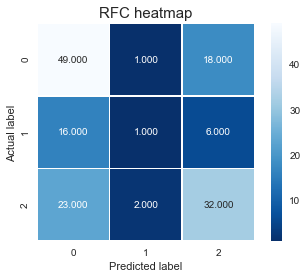

In [11]:
#cross validation default classifier
pd.options.display.max_rows = None

features = copy.drop(columns = ['Steps','Steps_class'])
label = copy['Steps_class']
skf = StratifiedKFold(n_splits=5, random_state = 1, shuffle = True)
rfc = RandomForestClassifier()

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(rfc, features, label, cv=skf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(rfc, features, label, cv=skf)
display(scores)

s=confusion_matrix(label, predicted)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('RFC heatmap', size = 15);

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = skf , verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([1.3923, 1.4761, 1.3434, 1.0093, 0.763 ]),
 'score_time': array([0.1007, 0.0977, 0.2583, 0.0778, 0.0509]),
 'estimator': [RandomForestClassifier(max_depth=30, n_estimators=400),
  RandomForestClassifier(max_depth=30, n_estimators=400),
  RandomForestClassifier(max_depth=30, n_estimators=400),
  RandomForestClassifier(max_depth=30, n_estimators=400),
  RandomForestClassifier(max_depth=30, n_estimators=400)],
 'test_accuracy': array([0.5667, 0.4333, 0.5333, 0.6552, 0.5172]),
 'test_precision_weighted': array([0.4833, 0.3741, 0.4437, 0.6648, 0.4713]),
 'test_recall_weighted': array([0.5667, 0.4333, 0.5333, 0.6552, 0.5172]),
 'test_f1_weighted': array([0.5173, 0.4   , 0.4844, 0.64  , 0.4643])}

Features sorted by their score for estimator 0:
                                          importance
Eigenvector                                 0.099403
Degree                                      0.098307
Betweeness                                  0.092322
Avg_Short_Path                              0.082899
Closeness                                   0.078360
Density                                     0.066297
ME_Internet_Game_Exposure_ME_Int_days_x     0.052206
ME_Internet_Game_Exposure_ME_Int_hours_x    0.051555
PA_Barriers_Resource_place_1                0.045760
Sportclub                                   0.033390
PA_motivation_PA_motiv_.intrin2_x           0.032059
PA_motivation_PA_motiv_.intrin3_x           0.029322
Meer_zee                                    0.028535
Speelplein                                  0.023045
Bos                                         0.022964
PA_motivation_PA_motiv_.extrin3_x           0.021810
PA_motivation_PA_motiv_.extrin1_x           0.02167

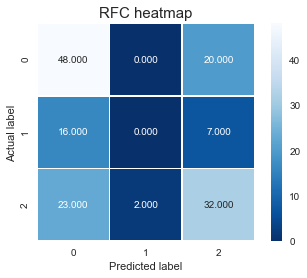

In [13]:
#cross validation optimized classifier
features = copy.drop(columns = ['Steps','Steps_class'])
label = copy['Steps_class']
best_random = rf_random.best_estimator_

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(best_random, features, label, cv=skf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(best_random, features, label, cv=skf)
display(scores)

s=confusion_matrix(label, predicted)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('RFC heatmap', size = 15);

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

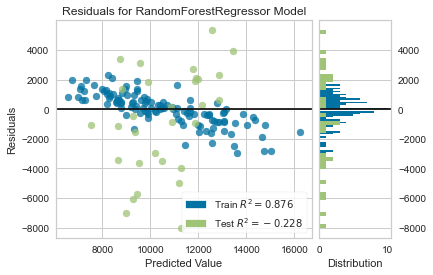

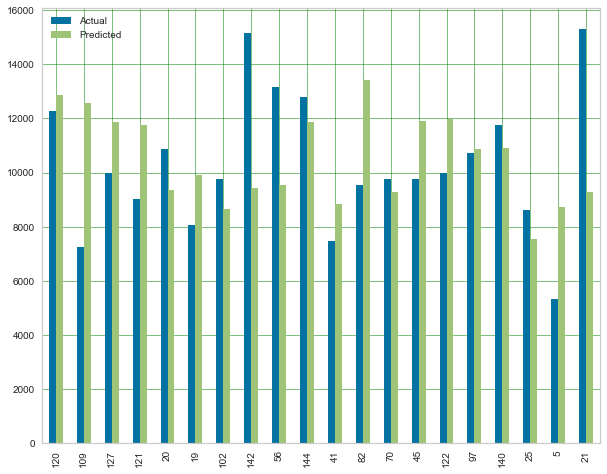

Mean Absolute Error: 2873.71 degrees.
Accuracy: 74.36 %.


In [14]:
# random forest regressor
pd.options.display.max_rows = None
features = copy.drop(columns = ['Steps','Steps_class'])
label_steps = full_table_57['Steps']

rf = RandomForestRegressor()
features_train, features_test, label_train, label_test = train_test_split(features, label_steps, test_size=0.2)

visualizer = ResidualsPlot(rf)
visualizer.fit(features_train, label_train)  # Fit the training data to the visualizer
visualizer.score(features_test, label_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

predictions = visualizer.predict(features_test)
df = pd.DataFrame({'Actual': label_test, 'Predicted': predictions})
df1 = df.head(20)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

errors = abs(predictions - label_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / label_test)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [15]:
#cross validation default regressor
kf = KFold(n_splits=5, random_state=2, shuffle=True)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
scores = cross_validate(rf, features, label_steps, cv=kf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(rf, features, label_steps, cv=kf)
display(scores)

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

{'fit_time': array([0.2533, 0.2094, 0.2194, 0.2244, 0.2453]),
 'score_time': array([0.012, 0.013, 0.012, 0.013, 0.014]),
 'estimator': [RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor()],
 'test_neg_mean_absolute_error': array([-2611.215 , -2675.1222, -2599.801 , -2177.2237, -2482.7081]),
 'test_neg_mean_squared_error': array([ -9828624.9111, -11609500.325 ,  -9803543.1322,  -8229548.0747,
         -8823612.2538]),
 'test_r2': array([ 0.1072, -0.1145, -0.0653,  0.0312, -0.0375]),
 'test_neg_mean_absolute_percentage_error': array([-0.3203, -0.2621, -0.258 , -0.2207, -0.2482])}

Features sorted by their score for estimator 0:
                                          importance
Betweeness                                  0.153564
Eigenvector                                 0.138791
Closeness                                   0.104806
Degree                                      0.104373
ME_Internet_Game_Exposure_ME_Int_hours_x    0.078137
Avg_Short_Path                              0.058381
Density                                     0.048547
ME_Internet_Game_Exposure_ME_Int_days_x     0.038038
PA_motivation_PA_motiv_.intrin2_x           0.034531
PA_Barriers_Resource_place_1                0.031620
Speelplein                                  0.026625
PA_motivation_PA_motiv_.extrin3_x           0.022136
Meer_zee                                    0.019361
Sportclub                                   0.019240
Grasveld                                    0.018650
Zwembad                                     0.016306
Speeltuin                                   0.01540

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = kf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label_steps)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100}

In [17]:
#cross validation optimized regressor
best_random_2 = rf_random.best_estimator_

scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
scores = cross_validate(best_random_2, features, label_steps, cv=kf, scoring=scoring, return_estimator = True)
predicted = cross_val_predict(best_random_2, features, label_steps, cv=kf)
display(scores)

for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = features.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

{'fit_time': array([1.7513, 1.5977, 1.7723, 2.9421, 2.5152]),
 'score_time': array([0.0878, 0.0987, 0.1775, 0.1965, 0.1292]),
 'estimator': [RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=1000),
  RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=1000),
  RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=1000),
  RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=1000),
  RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=1000)],
 'test_neg_mean_absolute_error': array([-2595.2498, -2624.8296, -2424.7721, -2130.0067, -2348.2661]),
 'test_neg_mean_squared_error': array([ -9406217.178 , -10488722.4882,  -8692256.1477,  -8113180.6469,
         -8519876.7043]),
 'test_r2

Features sorted by their score for estimator 0:
                                          importance
Betweeness                                  0.123524
Eigenvector                                 0.119170
Degree                                      0.104388
Closeness                                   0.099379
Density                                     0.071736
Avg_Short_Path                              0.068728
ME_Internet_Game_Exposure_ME_Int_hours_x    0.061214
ME_Internet_Game_Exposure_ME_Int_days_x     0.045097
PA_Barriers_Resource_place_1                0.031064
PA_motivation_PA_motiv_.intrin2_x           0.030561
Speelplein                                  0.027910
Sportclub                                   0.026691
PA_motivation_PA_motiv_.extrin3_x           0.024670
Sporthal                                    0.020311
Park                                        0.019840
Meer_zee                                    0.019068
Grasveld                                    0.01682

In [18]:
final1 = best_random.fit(features, label)
print("Features sorted by their score for estimator {}:".format(idx))
feature_importances = pd.DataFrame(final1.feature_importances_, index = features.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

final2 = best_random_2.fit(features, label_steps)
print("Features sorted by their score for estimator {}:".format(idx))
feature_importances = pd.DataFrame(final2.feature_importances_, index = features.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

Features sorted by their score for estimator 4:
                                          importance
Eigenvector                                 0.120332
Avg_Short_Path                              0.104491
Degree                                      0.100026
Betweeness                                  0.096751
Density                                     0.095868
Closeness                                   0.085784
ME_Internet_Game_Exposure_ME_Int_days_x     0.051836
ME_Internet_Game_Exposure_ME_Int_hours_x    0.044463
Sportclub                                   0.043587
PA_Barriers_Resource_place_1                0.034490
PA_motivation_PA_motiv_.intrin2_x           0.028181
Speelplein                                  0.027250
Park                                        0.019153
Grasveld                                    0.018819
Sporthal                                    0.018415
PA_motivation_PA_motiv_.intrin3_x           0.018231
Bos                                         0.01748